In [1]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import numpy as np
import string
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gc

In [2]:
train = pd.read_pickle('Preprocessing_Train.pkl')
X_train, X_test, y_train, y_test = train_test_split(train.document_text, train.label, test_size=0.25)

stop_words = stopwords.words('english')
non_neg_stop = [i for i in stop_words if "n't" not in i and "no" not in i]
lemma = WordNetLemmatizer()


def pos(x):
    if x.startswith('J'):
        return 'a'
    elif x.startswith('V'):
        return 'v'
    elif x.startswith('R'):
        return 'r'
    else:
        return 'n'
    
    
def tok(doc, non_neg=False, lemmatized=False):
    
    if non_neg:
        stop = non_neg_stop
    else:
        stop = stop_words
       
    tokens = re.split(r'\s', doc.lower())
    
    if lemmatized:
        pos_list = nltk.pos_tag(tokens)
        tokens = list(map(lambda x: lemma.lemmatize(x[0], pos(x[1])), pos_list))    

    tokens = [i for i in tokens if i not in stop]
    tokens = [i for i in tokens if len(re.findall(r'\w', i)) >= 2]
    tokens = [re.findall(r"\w[a-zA-Z0-9.-]*\w", i)[0] for i in tokens if re.findall(r"\w[a-zA-Z0-9.-]*\w", i)]
    
    return tokens


def get_voc_new(X, non_neg=True, lemmatized=True):
    
    voc = []
    token_list = []
    for i in X:
        tokens = tok(i, non_neg, lemmatized)
        token_list.append(tokens)
        voc += tokens
        
    voc = list(set(voc))
    
    return voc, token_list

In [3]:
voc, tk_list_train = get_voc_new(X_train, False, True)
# voc, tk_list_train = get_voc_new(train.document_text, False, True)
voc_test, tk_list_test = get_voc_new(X_test, False, True)
voc_dic = {item: idx+1 for idx, item in enumerate(voc)}

In [4]:
def word2idx(token_list):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token in voc_dic:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx


tk_idx_train = word2idx(tk_list_train)
tk_idx_test = word2idx(tk_list_test)

In [5]:
tfidf = TfidfVectorizer(vocabulary=voc)
vec_train = tfidf.fit_transform(X_train)
vec_test = tfidf.transform(X_test)

class _dataset(Dataset):
    
    def __init__(self, X, y):
        super(_dataset, self).__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
_train = _dataset(vec_train.toarray(), np.array(list(y_train)))
_test = _dataset(vec_test.toarray(), np.array(list(y_test)))


In [18]:
class EndConv(nn.Module):
    
    def __init__(self):
        super(EndConv, self).__init__()
        self.ecv = nn.Sequential(
            nn.Conv1d(1, 256, 128),
            nn.ReLU())

    def forward(self, x):
        Z = self.ecv(x.unsqueeze(-1).transpose(-2, -1))
        return nn.MaxPool1d(Z.size(-1))(Z).squeeze(-1)


# class Conv(nn.Module):
    
#     def __init__(self):
#         super(Conv, self).__init__()
#         self.cv = nn.Sequential(
#             nn.Conv1d(1, 64, 64),
#             nn.ReLU(),
#             nn.MaxPool1d(1024, 512))

#     def forward(self, x):
#         return self.cv(x.unsqueeze(-1).transpose(-2,-1)).transpose(-2,-1)


# class Att(nn.Module):
    
#     def __init__(self, dim_emb=256, dim_enc=50):
#         super(Att, self).__init__()
#         self.Wq = nn.Linear(dim_emb, dim_enc, bias=False)
#         self.Wk = nn.Linear(dim_emb, dim_emb, bias=False)
#         self.Wv = nn.Linear(dim_emb, dim_emb, bias=False)

#     def forward(self, x):
#         K = self.Wk(x)
#         V = self.Wv(x)
#         temp = self.Wq(K) 
#         score = temp.transpose(-2, -1) / math.sqrt(K.size(-1))
#         return torch.matmul(nn.Softmax(dim=-1)(score), V)
    
    
# class LN(nn.Module):
    
#     def __init__(self, dim_emb=256):
#         super(LN, self).__init__()
#         self.feed = nn.LayerNorm(dim_emb)

#     def forward(self, x):
#         return x + self.feed(x)


class final_model(nn.Module):
    
    def __init__(self, voc_size=len(voc)+1, dim_emb=256, dropout=0.5, max_len=1024):
        super(final_model, self).__init__()
        self.net = nn.Sequential(
            EndConv(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 50),
            nn.Sigmoid())
            
    def forward(self, x):
        return self.net(x)

In [19]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'detail_train': [], 'detail_eval': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    save_loss = nn.BCELoss(reduction='none').to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        detail_train = torch.zeros(50).to(device)
        detail_eval = torch.zeros(50).to(device)
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            loss = Loss(out, y)
            save_train = save_loss(out, y).sum(0)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            detail_train += save_train
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X).squeeze(-1)
                loss = Loss(out, y)
                save_eval = save_loss(out, y).sum(0)
                detail_eval += save_eval
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['detail_train'].append(detail_train.cpu().detach())
        history['detail_eval'].append(detail_eval.cpu().detach())  
        
        if not (epoch+1)%10:
            print(f"epoch {epoch+1}\ntrain loss: {train_loss}\t\teval loss: {eval_loss}")
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(f"f1_score for 50 classes: {f1_score(tru, np.round(res), average='macro')}")
            print(classification_report(tru, np.round(res)))
#             print(classification_report(tru, np.round(res), target_names=['8','22','35']))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    return history

In [20]:
torch.cuda.empty_cache()
gc.collect()

316

In [21]:

mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 256
norm = None

hist = train_model(mod, _train, _test, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

Training start!


RuntimeError: CUDA out of memory. Tried to allocate 8.46 GiB (GPU 0; 6.00 GiB total capacity; 68.47 MiB already allocated; 3.94 GiB free; 70.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Training start!
epoch 10
train loss: 0.19789904356002808		eval loss: 0.19607852399349213
epoch 20
train loss: 0.11642402410507202		eval loss: 0.12662045657634735
epoch 30
train loss: 0.0782708153128624		eval loss: 0.11894180625677109
epoch 40
train loss: 0.05474073812365532		eval loss: 0.11974044144153595
epoch 50
train loss: 0.04002870246767998		eval loss: 0.15997473895549774

epoch 50:

f1_score for 50 classes: 0.7899181513241395
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       224
           1       0.95      0.76      0.85       251
           2       0.96      0.84      0.90       260
           3       0.92      0.82      0.87       169
           4       0.95      0.91      0.93       191
           5       0.88      0.93      0.91       338
           6       0.95      0.88      0.91       246
           7       0.91      0.72      0.81       318
           8       0.85      0.63      0.73       126
           9       0.83

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 60
train loss: 0.030421320348978043		eval loss: 0.1490205079317093
epoch 70
train loss: 0.02225392870604992		eval loss: 0.17372974753379822
epoch 80
train loss: 0.01945211924612522		eval loss: 0.18585078418254852
epoch 90
train loss: 0.01612626388669014		eval loss: 0.1948976367712021
epoch 100
train loss: 0.013661335222423077		eval loss: 0.19307349622249603

epoch 100:

f1_score for 50 classes: 0.8191482104607304
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       224
           1       0.92      0.82      0.87       251
           2       0.94      0.85      0.89       260
           3       0.93      0.80      0.86       169
           4       0.94      0.91      0.92       191
           5       0.88      0.95      0.91       338
           6       0.94      0.90      0.92       246
           7       0.91      0.76      0.83       318
           8       0.83      0.67      0.75       126
           9       0.74      0.65   

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 110
train loss: 0.011798602528870106		eval loss: 0.22183285653591156
epoch 120
train loss: 0.010646900162100792		eval loss: 0.2363666146993637
epoch 130
train loss: 0.008900748565793037		eval loss: 0.23878370225429535
epoch 140
train loss: 0.008311294950544834		eval loss: 0.2252567857503891
epoch 150
train loss: 0.0077290828339755535		eval loss: 0.227946475148201

epoch 150:

f1_score for 50 classes: 0.8195298765293844
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       224
           1       0.89      0.83      0.86       251
           2       0.93      0.85      0.89       260
           3       0.91      0.84      0.87       169
           4       0.91      0.92      0.92       191
           5       0.87      0.96      0.91       338
           6       0.93      0.90      0.92       246
           7       0.85      0.78      0.82       318
           8       0.80      0.68      0.74       126
           9       0.73      0

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 160
train loss: 0.0068707335740327835		eval loss: 0.24622474610805511
epoch 170
train loss: 0.00618921360000968		eval loss: 0.2814781665802002
epoch 180
train loss: 0.00625342782586813		eval loss: 0.20178118348121643
epoch 190
train loss: 0.0062814936973154545		eval loss: 0.23518644273281097
epoch 200
train loss: 0.005374311935156584		eval loss: 0.2540018558502197

epoch 200:

f1_score for 50 classes: 0.8205775956054824
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       224
           1       0.91      0.80      0.86       251
           2       0.92      0.86      0.89       260
           3       0.93      0.84      0.88       169
           4       0.93      0.88      0.90       191
           5       0.88      0.93      0.91       338
           6       0.94      0.90      0.92       246
           7       0.86      0.81      0.83       318
           8       0.81      0.69      0.75       126
           9       0.70      

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


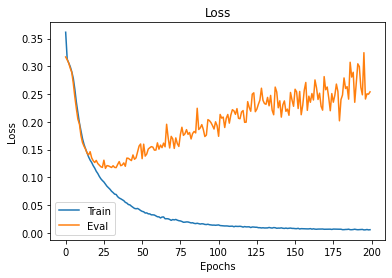

In [40]:
## Embedding_shallower but wider 256*3
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 128
norm = None

hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

Training start!
epoch 10
train loss: 0.20334823429584503		eval loss: 0.2193826287984848
epoch 20
train loss: 0.11933037638664246		eval loss: 0.1283724308013916
epoch 30
train loss: 0.07949564605951309		eval loss: 0.12263929843902588
epoch 40
train loss: 0.0556238554418087		eval loss: 0.12575559318065643
epoch 50
train loss: 0.0400378592312336		eval loss: 0.13247595727443695

epoch 50:

f1_score for 50 classes: 0.804003221532673
              precision    recall  f1-score   support

           0       0.93      0.74      0.82       224
           1       0.87      0.82      0.84       251
           2       0.91      0.86      0.89       260
           3       0.95      0.83      0.89       169
           4       0.88      0.93      0.90       191
           5       0.88      0.93      0.90       338
           6       0.92      0.88      0.90       246
           7       0.84      0.86      0.85       318
           8       0.79      0.60      0.68       126
           9       0.80    

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 60
train loss: 0.02990969642996788		eval loss: 0.15203748643398285
epoch 70
train loss: 0.023364661261439323		eval loss: 0.149562805891037
epoch 80
train loss: 0.018716024234890938		eval loss: 0.1729631870985031
epoch 90
train loss: 0.014972594566643238		eval loss: 0.20658040046691895
epoch 100
train loss: 0.013581608422100544		eval loss: 0.16993990540504456

epoch 100:

f1_score for 50 classes: 0.8177438514173571
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       224
           1       0.90      0.84      0.87       251
           2       0.92      0.86      0.89       260
           3       0.94      0.86      0.90       169
           4       0.93      0.95      0.94       191
           5       0.88      0.91      0.90       338
           6       0.92      0.89      0.91       246
           7       0.85      0.86      0.85       318
           8       0.73      0.63      0.68       126
           9       0.72      0.67  

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 110
train loss: 0.01133616641163826		eval loss: 0.20658698678016663
epoch 120
train loss: 0.01006733812391758		eval loss: 0.18896853923797607
epoch 130
train loss: 0.009496072307229042		eval loss: 0.21549272537231445
epoch 140
train loss: 0.008381159044802189		eval loss: 0.23306719958782196
epoch 150
train loss: 0.007227981463074684		eval loss: 0.2514427602291107

epoch 150:

f1_score for 50 classes: 0.8201153301887306
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       224
           1       0.92      0.85      0.88       251
           2       0.90      0.87      0.88       260
           3       0.95      0.85      0.90       169
           4       0.91      0.93      0.92       191
           5       0.88      0.91      0.90       338
           6       0.93      0.90      0.91       246
           7       0.89      0.81      0.84       318
           8       0.79      0.64      0.71       126
           9       0.77      0

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 160
train loss: 0.006607775576412678		eval loss: 0.2620411813259125
epoch 170
train loss: 0.006697102915495634		eval loss: 0.25648126006126404
epoch 180
train loss: 0.005812198854982853		eval loss: 0.25479570031166077
epoch 190
train loss: 0.005289084743708372		eval loss: 0.24706295132637024
epoch 200
train loss: 0.005550635978579521		eval loss: 0.2357543557882309

epoch 200:

f1_score for 50 classes: 0.8206061348712459
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       224
           1       0.92      0.85      0.88       251
           2       0.93      0.86      0.89       260
           3       0.94      0.85      0.89       169
           4       0.93      0.94      0.93       191
           5       0.89      0.90      0.90       338
           6       0.94      0.89      0.91       246
           7       0.88      0.81      0.84       318
           8       0.76      0.61      0.68       126
           9       0.74      

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


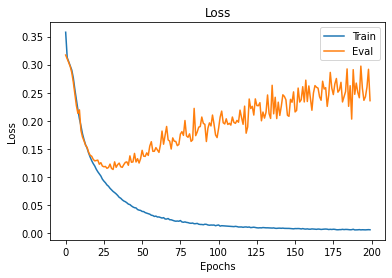

In [33]:
# Embedding Shallower 256*3
# 35和8复杂，22简单？
mod = final_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 128
norm = None

hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

In [46]:
tfidf = TfidfVectorizer(vocabulary=voc)
vec_train = tfidf.fit_transform(X_train)
vec_test = tfidf.transform(X_test)

class _dataset(Dataset):
    
    def __init__(self, X, y):
        super(_dataset, self).__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
_train = _dataset(vec_train.toarray(), np.array(list(y_train)))
_test = _dataset(vec_test.toarray(), np.array(list(y_test)))
class MLP_model(nn.Module):
    
    def __init__(self):

        super(MLP_model, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(vec_train.shape[1], 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.Sigmoid())

            
    def forward(self, x):
        return self.net(x)

Training start!
epoch 10
train loss: 0.21831580996513367		eval loss: 0.22929878532886505
epoch 20
train loss: 0.14005769789218903		eval loss: 0.17516420781612396
epoch 30
train loss: 0.08362284302711487		eval loss: 0.14622800052165985
epoch 40
train loss: 0.04694589972496033		eval loss: 0.13391344249248505
epoch 50
train loss: 0.026620447635650635		eval loss: 0.13217030465602875

epoch 50:

f1_score for 50 classes: 0.7221689941737508
              precision    recall  f1-score   support

           0       0.87      0.50      0.63       230
           1       0.98      0.69      0.81       242
           2       0.86      0.64      0.74       266
           3       0.90      0.69      0.78       168
           4       0.92      0.78      0.85       181
           5       0.89      0.63      0.74       357
           6       0.95      0.64      0.77       258
           7       0.93      0.72      0.81       316
           8       0.75      0.32      0.45       134
           9       0.

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 60
train loss: 0.01579935848712921		eval loss: 0.13630959391593933
epoch 70
train loss: 0.009905390441417694		eval loss: 0.14313636720180511
epoch 80
train loss: 0.00652848556637764		eval loss: 0.1499459445476532
epoch 90
train loss: 0.004484423901885748		eval loss: 0.15843138098716736
epoch 100
train loss: 0.0031903989147394896		eval loss: 0.16545139253139496

epoch 100:

f1_score for 50 classes: 0.7453847506263519
              precision    recall  f1-score   support

           0       0.83      0.54      0.65       230
           1       0.96      0.71      0.82       242
           2       0.86      0.67      0.76       266
           3       0.90      0.73      0.81       168
           4       0.91      0.80      0.85       181
           5       0.89      0.67      0.76       357
           6       0.92      0.67      0.78       258
           7       0.93      0.73      0.82       316
           8       0.76      0.41      0.53       134
           9       0.86      0.57

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 110
train loss: 0.002338390564545989		eval loss: 0.17372126877307892
epoch 120
train loss: 0.0017595629906281829		eval loss: 0.18163758516311646
epoch 130
train loss: 0.0013565381523221731		eval loss: 0.1883552074432373
epoch 140
train loss: 0.001072741113603115		eval loss: 0.19645927846431732
epoch 150
train loss: 0.0008616959094069898		eval loss: 0.2024856060743332

epoch 150:

f1_score for 50 classes: 0.7449204621152767
              precision    recall  f1-score   support

           0       0.82      0.54      0.65       230
           1       0.96      0.71      0.82       242
           2       0.85      0.68      0.76       266
           3       0.91      0.74      0.82       168
           4       0.90      0.78      0.84       181
           5       0.87      0.68      0.76       357
           6       0.91      0.68      0.78       258
           7       0.93      0.72      0.81       316
           8       0.73      0.40      0.51       134
           9       0.85   

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 160
train loss: 0.0007075810572132468		eval loss: 0.21078169345855713
epoch 170
train loss: 0.0005913428030908108		eval loss: 0.21635471284389496
epoch 180
train loss: 0.0005071648629382253		eval loss: 0.22354045510292053
epoch 190
train loss: 0.0004368145018815994		eval loss: 0.22929690778255463
epoch 200
train loss: 0.0003836801915895194		eval loss: 0.2361086905002594

epoch 200:

f1_score for 50 classes: 0.7440022568278818
              precision    recall  f1-score   support

           0       0.81      0.55      0.66       230
           1       0.95      0.72      0.82       242
           2       0.85      0.70      0.76       266
           3       0.88      0.74      0.81       168
           4       0.90      0.78      0.84       181
           5       0.86      0.69      0.77       357
           6       0.91      0.69      0.78       258
           7       0.93      0.71      0.81       316
           8       0.73      0.39      0.51       134
           9       0.81

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


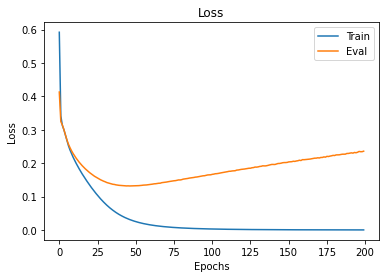

In [47]:
mod_ez = MLP_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
lr = 3e-4
batch_size = 128
norm = None

hist = train_model(mod_ez, _train, _test, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

In [37]:
save = []
for x in [8, 22, 35]:
    mb = []
    for i in range(50):
        dom = 0
        non_dom = 0
        count_1 = 0
        count_2 = 0
        nc_1 = 0
        nc_2 = 0
        if i not in [8, 22, 35]:
            for j in train.label_idx:
                if i in j:
                    dom += 1
                    if x in j:
                        count_1 += 1
                    else:
                        nc_1 += 1
                else:
                    non_dom += 1
                    if x in j:
                        count_2 += 1
                    else:
                        nc_2 += 1
            mb.append((count_1/dom, count_2/non_dom, nc_1/dom, nc_2/non_dom))
    save.append(mb)

In [38]:
p_8 = save[0]
p_22 = save[1]
p_35 = save[2]

In [19]:
pred = []
with torch.no_grad():
    for X, y in DataLoader(test_, batch_size=256):
        X = X.to(device)
        y = y.to(device)
        out = mod(X).squeeze(-1)
        pred.append(out.cpu())

In [22]:
pre = torch.cat(pred)[:, [i for i in range(50) if i not in [8, 22, 35]]]

In [23]:
rea = test_.y[:, [i for i in range(50) if i not in [8, 22, 35]]]

In [32]:
(torch.matmul(pre, torch.Tensor(p_8)[:, 0].squeeze(-1)) + torch.matmul(1-pre, torch.Tensor(p_8)[:, 1].squeeze(-1)))

tensor([2.4130, 2.3769, 2.4704,  ..., 2.4017, 2.3848, 2.4934])

In [40]:
(torch.matmul(pre, torch.Tensor(p_8)[:, 2].squeeze(-1)) + torch.matmul(1-pre, torch.Tensor(p_8)[:, 3].squeeze(-1)))

tensor([44.5870, 44.6231, 44.5296,  ..., 44.5983, 44.6152, 44.5066])

In [33]:
(torch.matmul(pre, torch.Tensor(p_22)[:, 0].squeeze(-1)) + torch.matmul(1-pre, torch.Tensor(p_22)[:, 1].squeeze(-1)))

tensor([4.1435, 4.5474, 4.2090,  ..., 4.3982, 4.2331, 4.3111])

In [34]:
(torch.matmul(pre, torch.Tensor(p_35)[:, 0].squeeze(-1)) + torch.matmul(1-pre, torch.Tensor(p_35)[:, 1].squeeze(-1)))

tensor([3.7967, 3.8313, 3.8017,  ..., 3.8292, 3.9071, 3.9900])

In [44]:
test_.y[:, 8]

tensor([0., 0., 0.,  ..., 0., 0., 0.])